In [2]:
# Instalar librería simpy
!pip install simpy

In [3]:
# Cargar librerias
import random
import simpy
import math

In [ ]:
# Variables
semilla = 30
num_peluqueros = 2
tiempo_corte_min = 15
tiempo_corte_max = 30
t_llegada = 20
tot_clientes = 100
te = 0.0 # tiempo de espera total
dt = 0.0 # duración de servicio
fin = 0.0 # minuto en que finaliza

In [ ]:
# Procedimiento
def cortar(cliente):
  global dt
  R = random.random()
  tiempo = tiempo_corte_max - tiempo_corte_min
  tiempo_corte = tiempo_corte_min + tiempo * R # Distribución Uniforme
  yield env.timeout(tiempo_corte) # Dejamos correr el tiempo n minutos
  print("\o/ Corte listo a %s en %.2f minutos " % (cliente, tiempo_corte))
  dt = dt + tiempo_corte # Acumula los tiempos de uso de la instalación

In [ ]:
def cliente(env,name,personal):
  global te
  global fin
  llega = env.now # Guarda el minuto de llegada del cliente
  print("--> %s llegó a la peluquería en el minuto %.2f" % (name,llega))
  with personal.request() as request: # espera turno
    yield request # obtener turno
    pasa = env.now # guarda el minuto cuando comienza a ser atendido el cliente
    espera = pasa - llega
    te = te + espera # Acumular los tiempos de espera
    print("%s Pasa con peluquero en el minuto %.2f habiendo esperado %.2f" % (name, pasa, espera))
    yield env.process(cortar(name)) # Llamar al proceso cortar
    deja = env.now # guardamos el minuto en que termina el proceso
    print("<-- %s deja la peluquería en minuto %.2f" % (name,deja))
    fin = deja # Conservamos el último minuto de la simulación

In [ ]:
def principal(env,personal):
  llegada = 0
  i = 0
  for i in range(tot_clientes):
    R = random.random()
    llegada = - t_llegada * math.log(R)
    yield env.timeout(llegada) # Dejamos transcurrir un tiempo entre un cliente y otro
    i = i + 1
    env.process(cliente(env,"Cliente %d" % i, personal))

In [ ]:
# Programa principal
print("------- Simulación Peluquería---------")
random.seed(semilla)
env = simpy.Environment() # Creamos el entorno de simulación
personal = simpy.Resource(env,num_peluqueros) # Creamos los recursos peluqueros
env.process(principal(env,personal))
env.run() # Iniciamos simulación

------- Simulación Peluquería---------
--> Cliente 1 llegó a la peluquería en el minuto 12.36
Cliente 1 Pasa con peluquero en el minuto 12.36 habiendo esperado 0.00
\o/ Corte listo a Cliente 1 en 15.45 minutos 
<-- Cliente 1 deja la peluquería en minuto 27.81
--> Cliente 2 llegó a la peluquería en el minuto 37.17
Cliente 2 Pasa con peluquero en el minuto 37.17 habiendo esperado 0.00
--> Cliente 3 llegó a la peluquería en el minuto 45.67
Cliente 3 Pasa con peluquero en el minuto 45.67 habiendo esperado 0.00
\o/ Corte listo a Cliente 2 en 18.15 minutos 
<-- Cliente 2 deja la peluquería en minuto 55.32
\o/ Corte listo a Cliente 3 en 20.96 minutos 
<-- Cliente 3 deja la peluquería en minuto 66.63
--> Cliente 4 llegó a la peluquería en el minuto 72.83
Cliente 4 Pasa con peluquero en el minuto 72.83 habiendo esperado 0.00
--> Cliente 5 llegó a la peluquería en el minuto 81.70
Cliente 5 Pasa con peluquero en el minuto 81.70 habiendo esperado 0.00
--> Cliente 6 llegó a la peluquería en el minu

In [ ]:
# Salidas
print("Indicadores obtenidos:")
print("")

lpc = te/fin
print("Longitud promedio de la cola: %.2f" % lpc)

tep = te/tot_clientes
print("Tiempo de espera promedio: %.2f" % tep)

upi = (dt/fin)/num_peluqueros
print("Uso promedio de la instalación: %.2f" % upi)

Indicadores obtenidos:

Longitud promedio de la cola: 0.27
Tiempo de espera promedio: 5.33
Uso promedio de la instalación: 0.57


In [8]:
# -------------------------------------------
# Simulación de una peluquería con SimPy
# Modelo M/U/c (llegadas Poisson, servicio uniforme, c servidores)
# Incluye:
# - Registro de cada cliente
# - Métricas agregadas
# - Percentiles de espera
# - Utilización de los peluqueros
# - Tamaño promedio del sistema y de la cola
# - Función para correr varias réplicas
# -------------------------------------------

import random
import simpy
import math
import statistics as stats

# --------------------------
# Parámetros del modelo
# --------------------------
SEMILLA = 30
NUM_PELUQUEROS = 2
TIEMPO_CORTE_MIN = 15.0
TIEMPO_CORTE_MAX = 30.0
# media entre llegadas (parámetro de la exponencial)
MEDIA_LLEGADAS = 20.0
TOT_CLIENTES = 10000

random.seed(SEMILLA)

def tiempo_servicio():
    """Servicio ~ Uniforme(a,b)."""
    return random.uniform(TIEMPO_CORTE_MIN, TIEMPO_CORTE_MAX)

def tiempo_entre_llegadas():
    """Llegadas ~ Exponencial(media = MEDIA_LLEGADAS)."""
    # exponencial con media = MEDIA_LLEGADAS
    r = random.random()
    return -MEDIA_LLEGADAS * math.log(r)

class Peluqueria:
    def __init__(self, env, num_peluqueros):
        self.env = env
        self.peluqueros = simpy.Resource(env, capacity=num_peluqueros)

        # Para métricas
        self.datos_clientes = []   # acá guardamos dicts con info de cada cliente
        self.tiempo_ocupado = 0.0  # suma de tiempos de servicio (para utilización)
        self.num_peluqueros = num_peluqueros

        # Para estimar tamaño promedio del sistema por "area under curve"
        self.last_event_time = 0.0
        self.num_in_system = 0     # clientes en sistema
        self.area_num_in_system = 0.0

    def actualizar_area(self):
        """Actualiza el área bajo la curva de número en el sistema."""
        now = self.env.now
        dt = now - self.last_event_time
        self.area_num_in_system += self.num_in_system * dt
        self.last_event_time = now

    def llegar_cliente(self, nombre):
        """Proceso de un cliente."""
        # Llega
        self.actualizar_area()
        self.num_in_system += 1   # entra al sistema

        instante_llegada = self.env.now
        # espera peluquero
        with self.peluqueros.request() as req:
            yield req
            # Comienza a ser atendido
            instante_inicio = self.env.now
            tiempo_espera = instante_inicio - instante_llegada

            # Servicio
            duracion = tiempo_servicio()
            self.tiempo_ocupado += duracion
            yield self.env.timeout(duracion)
            instante_salida = self.env.now

        # Sale del sistema
        self.actualizar_area()
        self.num_in_system -= 1

        # Guardar datos del cliente
        self.datos_clientes.append({
            "cliente": nombre,
            "llegada": instante_llegada,
            "inicio": instante_inicio,
            "salida": instante_salida,
            "espera": tiempo_espera,
            "servicio": duracion,
            "tiempo_sistema": instante_salida - instante_llegada
        })

def generador_clientes(env, peluqueria, tot_clientes):
    """Genera clientes con tiempos de llegada exponenciales."""
    for i in range(1, tot_clientes + 1):
        # crear proceso cliente
        env.process(peluqueria.llegar_cliente(f"Cliente {i}"))
        # esperar siguiente llegada
        if i < tot_clientes:
            inter = tiempo_entre_llegadas()
            yield env.timeout(inter)

def correr_una_simulacion(tot_clientes=TOT_CLIENTES):
    """Corre UNA simulación y devuelve las métricas."""
    env = simpy.Environment()
    peluqueria = Peluqueria(env, NUM_PELUQUEROS)
    env.process(generador_clientes(env, peluqueria, tot_clientes))
    env.run()  # corre hasta que terminen todos

    # ------------------------------------
    # Cálculo de métricas
    # ------------------------------------
    datos = peluqueria.datos_clientes
    fin = env.now  # tiempo total simulado

    # Listas auxiliares
    esperas = [d["espera"] for d in datos]
    servicios = [d["servicio"] for d in datos]
    tiempos_sistema = [d["tiempo_sistema"] for d in datos]

    # Métricas básicas
    espera_prom = stats.mean(esperas) if esperas else 0.0
    servicio_prom = stats.mean(servicios) if servicios else 0.0
    tiempo_sistema_prom = stats.mean(tiempos_sistema) if tiempos_sistema else 0.0

    # Percentiles de espera
    esperas_sorted = sorted(esperas)
    def p(lst, q):
        if not lst:
            return 0.0
        idx = int(q * (len(lst) - 1))
        return lst[idx]

    p50_espera = p(esperas_sorted, 0.50)
    p90_espera = p(esperas_sorted, 0.90)
    p95_espera = p(esperas_sorted, 0.95)

    # Utilización (tiempo ocupado total / (tiempo simulado * #servidores))
    utilizacion = (peluqueria.tiempo_ocupado / fin) / peluqueria.num_peluqueros

    # Tamaño promedio del sistema (L)
    L_prom = peluqueria.area_num_in_system / fin

    # Si quiero la cola promedio, puedo restar la cantidad de servidores efectiva.
    # Aproximación: cola promedio = L_prom - utilización * #servidores
    cola_prom = L_prom - utilizacion * peluqueria.num_peluqueros
    if cola_prom < 0:
        cola_prom = 0.0  # numérico

    resultados = {
        "tiempo_simulado": fin,
        "n_clientes": len(datos),
        "espera_prom": espera_prom,
        "servicio_prom": servicio_prom,
        "tiempo_sistema_prom": tiempo_sistema_prom,
        "p50_espera": p50_espera,
        "p90_espera": p90_espera,
        "p95_espera": p95_espera,
        "utilizacion": utilizacion,
        "L_prom": L_prom,
        "cola_prom": cola_prom,
        "raw": datos  # por si queremos analizar después
    }

    return resultados

# ---------------------------------------------------------
# Correr una simulación y mostrar resultados
# ---------------------------------------------------------
if __name__ == "__main__":
    res = correr_una_simulacion()

    print("------- Simulación Peluquería --------")
    print(f"Tiempo total simulado: {res['tiempo_simulado']:.2f} minutos")
    print(f"Clientes atendidos: {res['n_clientes']}")
    print("")
    print(f"Tiempo de espera promedio (Wq): {res['espera_prom']:.2f} min")
    print(f"Tiempo en el sistema promedio (W): {res['tiempo_sistema_prom']:.2f} min")
    print(f"Tiempo de servicio promedio: {res['servicio_prom']:.2f} min")
    print("")
    print(f"Percentil 50 de espera: {res['p50_espera']:.2f} min")
    print(f"Percentil 90 de espera: {res['p90_espera']:.2f} min")
    print(f"Percentil 95 de espera: {res['p95_espera']:.2f} min")
    print("")
    print(f"Utilización promedio de los {NUM_PELUQUEROS} peluqueros: {res['utilizacion']*100:.1f}%")
    print(f"Tamaño promedio del sistema (L): {res['L_prom']:.2f} clientes")
    print(f"Longitud promedio de la cola (Lq): {res['cola_prom']:.2f} clientes")


------- Simulación Peluquería --------
Tiempo total simulado: 201432.51 minutos
Clientes atendidos: 10000

Tiempo de espera promedio (Wq): 5.16 min
Tiempo en el sistema promedio (W): 27.62 min
Tiempo de servicio promedio: 22.46 min

Percentil 50 de espera: 0.00 min
Percentil 90 de espera: 18.36 min
Percentil 95 de espera: 24.58 min

Utilización promedio de los 2 peluqueros: 55.8%
Tamaño promedio del sistema (L): 1.37 clientes
Longitud promedio de la cola (Lq): 0.26 clientes


In [10]:
# -------------------------------------------
# Simulación de una peluquería con SimPy
# Versión con réplicas
# -------------------------------------------
import random
import simpy
import math
import statistics as stats
from math import sqrt

# --------------------------
# Parámetros base del modelo
# --------------------------
SEMILLA_BASE = 30
NUM_PELUQUEROS = 2
TIEMPO_CORTE_MIN = 15.0
TIEMPO_CORTE_MAX = 30.0
MEDIA_LLEGADAS = 20.0
TOT_CLIENTES = 100

def tiempo_servicio():
    """Servicio ~ Uniforme(a,b)."""
    return random.uniform(TIEMPO_CORTE_MIN, TIEMPO_CORTE_MAX)

def tiempo_entre_llegadas():
    """Llegadas ~ Exponencial(media = MEDIA_LLEGADAS)."""
    r = random.random()
    return -MEDIA_LLEGADAS * math.log(r)

class Peluqueria:
    def __init__(self, env, num_peluqueros):
        self.env = env
        self.peluqueros = simpy.Resource(env, capacity=num_peluqueros)

        # Métricas
        self.datos_clientes = []
        self.tiempo_ocupado = 0.0
        self.num_peluqueros = num_peluqueros

        # Para L promedio (área bajo la curva)
        self.last_event_time = 0.0
        self.num_in_system = 0
        self.area_num_in_system = 0.0

    def actualizar_area(self):
        now = self.env.now
        dt = now - self.last_event_time
        self.area_num_in_system += self.num_in_system * dt
        self.last_event_time = now

    def llegar_cliente(self, nombre):
        # Llega al sistema
        self.actualizar_area()
        self.num_in_system += 1

        llegada = self.env.now
        with self.peluqueros.request() as req:
            yield req
            inicio = self.env.now
            espera = inicio - llegada

            duracion = tiempo_servicio()
            self.tiempo_ocupado += duracion
            yield self.env.timeout(duracion)
            salida = self.env.now

        # Sale del sistema
        self.actualizar_area()
        self.num_in_system -= 1

        self.datos_clientes.append({
            "cliente": nombre,
            "llegada": llegada,
            "inicio": inicio,
            "salida": salida,
            "espera": espera,
            "servicio": duracion,
            "tiempo_sistema": salida - llegada
        })

def generador_clientes(env, peluqueria, tot_clientes):
    for i in range(1, tot_clientes + 1):
        env.process(peluqueria.llegar_cliente(f"Cliente {i}"))
        if i < tot_clientes:
            inter = tiempo_entre_llegadas()
            yield env.timeout(inter)

def correr_una_simulacion(tot_clientes=TOT_CLIENTES):
    env = simpy.Environment()
    peluqueria = Peluqueria(env, NUM_PELUQUEROS)
    env.process(generador_clientes(env, peluqueria, tot_clientes))
    env.run()

    datos = peluqueria.datos_clientes
    fin = env.now

    esperas = [d["espera"] for d in datos]
    servicios = [d["servicio"] for d in datos]
    tiempos_sistema = [d["tiempo_sistema"] for d in datos]

    espera_prom = stats.mean(esperas) if esperas else 0.0
    servicio_prom = stats.mean(servicios) if servicios else 0.0
    tiempo_sistema_prom = stats.mean(tiempos_sistema) if tiempos_sistema else 0.0

    esperas_sorted = sorted(esperas)
    def p(lst, q):
        if not lst:
            return 0.0
        idx = int(q * (len(lst) - 1))
        return lst[idx]

    p50_espera = p(esperas_sorted, 0.50)
    p90_espera = p(esperas_sorted, 0.90)
    p95_espera = p(esperas_sorted, 0.95)

    utilizacion = (peluqueria.tiempo_ocupado / fin) / peluqueria.num_peluqueros
    L_prom = peluqueria.area_num_in_system / fin
    cola_prom = L_prom - utilizacion * peluqueria.num_peluqueros
    if cola_prom < 0:
        cola_prom = 0.0

    return {
        "tiempo_simulado": fin,
        "n_clientes": len(datos),
        "espera_prom": espera_prom,
        "servicio_prom": servicio_prom,
        "tiempo_sistema_prom": tiempo_sistema_prom,
        "p50_espera": p50_espera,
        "p90_espera": p90_espera,
        "p95_espera": p95_espera,
        "utilizacion": utilizacion,
        "L_prom": L_prom,
        "cola_prom": cola_prom
    }

# ---------------------------------------------------------
# Funciones auxiliares para réplicas
# ---------------------------------------------------------

def ic_95(muestra):
    """Devuelve (media, li, ls) del IC 95% asumiendo n>30."""
    n = len(muestra)
    media = stats.mean(muestra)
    desvio = stats.pstdev(muestra) if n > 1 else 0.0  # var poblacional
    # para muestras podés usar stats.stdev
    if n > 1:
        error = 1.96 * desvio / sqrt(n)
    else:
        error = 0.0
    return media, media - error, media + error

def correr_varias_replicas(n_replicas=20, tot_clientes=TOT_CLIENTES):
    resultados = []
    for r in range(n_replicas):
        # cambiar semilla para cada réplica
        random.seed(SEMILLA_BASE + r)
        res = correr_una_simulacion(tot_clientes=tot_clientes)
        resultados.append(res)
    return resultados

# ---------------------------------------------------------
# Programa principal
# ---------------------------------------------------------
if __name__ == "__main__":
    N_REPLICAS = 10000
    resultados = correr_varias_replicas(n_replicas=N_REPLICAS)

    # armar listas por métrica
    esperas = [r["espera_prom"] for r in resultados]
    tiempos_sistema = [r["tiempo_sistema_prom"] for r in resultados]
    utilizaciones = [r["utilizacion"] for r in resultados]
    colas = [r["cola_prom"] for r in resultados]

    m_esp, li_esp, ls_esp = ic_95(esperas)
    m_ts, li_ts, ls_ts = ic_95(tiempos_sistema)
    m_ut, li_ut, ls_ut = ic_95(utilizaciones)
    m_cola, li_cola, ls_cola = ic_95(colas)

    print("=========== RESULTADOS POR RÉPLICAS ===========")
    print(f"Réplicas: {N_REPLICAS}")
    print("")
    print("Tiempo de espera promedio (Wq):")
    print(f"  media = {m_esp:.2f}  IC95% = [{li_esp:.2f} , {ls_esp:.2f}]")
    print("")
    print("Tiempo en el sistema promedio (W):")
    print(f"  media = {m_ts:.2f}  IC95% = [{li_ts:.2f} , {ls_ts:.2f}]")
    print("")
    print("Utilización promedio de los servidores:")
    print(f"  media = {m_ut*100:.1f}%  IC95% = [{li_ut*100:.1f}% , {ls_ut*100:.1f}%]")
    print("")
    print("Longitud promedio de la cola (Lq):")
    print(f"  media = {m_cola:.2f}  IC95% = [{li_cola:.2f} , {ls_cola:.2f}]")
    print("")
    print("----------- Nota -----------")
    print("Podés aumentar N_REPLICAS para que el IC se haga más angosto.")


=========== RESULTADOS POR RÉPLICAS ===========
Réplicas: 10000

Tiempo de espera promedio (Wq):
  media = 5.39  IC95% = [5.34 , 5.45]

Tiempo en el sistema promedio (W):
  media = 27.88  IC95% = [27.83 , 27.94]

Utilización promedio de los servidores:
  media = 56.5%  IC95% = [56.4% , 56.6%]

Longitud promedio de la cola (Lq):
  media = 0.28  IC95% = [0.28 , 0.28]

----------- Nota -----------
Podés aumentar N_REPLICAS para que el IC se haga más angosto.


In [11]:
# -------------------------------------------
# Simulación Peluquería con comparación de escenarios
# -------------------------------------------
import random
import simpy
import math
import statistics as stats
from math import sqrt
import pandas as pd

# ==========================
# FUNCIONES DEL MODELO BASE
# ==========================

def tiempo_servicio(min_serv, max_serv):
    return random.uniform(min_serv, max_serv)

def tiempo_entre_llegadas(media_llegadas):
    r = random.random()
    return -media_llegadas * math.log(r)

class Peluqueria:
    def __init__(self, env, num_peluqueros, min_serv, max_serv):
        self.env = env
        self.peluqueros = simpy.Resource(env, capacity=num_peluqueros)
        self.min_serv = min_serv
        self.max_serv = max_serv
        self.tiempo_ocupado = 0.0
        self.num_peluqueros = num_peluqueros
        self.datos_clientes = []

        self.last_event_time = 0.0
        self.num_in_system = 0
        self.area_num_in_system = 0.0

    def actualizar_area(self):
        now = self.env.now
        dt = now - self.last_event_time
        self.area_num_in_system += self.num_in_system * dt
        self.last_event_time = now

    def llegar_cliente(self, nombre):
        self.actualizar_area()
        self.num_in_system += 1

        llegada = self.env.now
        with self.peluqueros.request() as req:
            yield req
            inicio = self.env.now
            espera = inicio - llegada

            duracion = tiempo_servicio(self.min_serv, self.max_serv)
            self.tiempo_ocupado += duracion
            yield self.env.timeout(duracion)
            salida = self.env.now

        self.actualizar_area()
        self.num_in_system -= 1

        self.datos_clientes.append({
            "cliente": nombre,
            "llegada": llegada,
            "inicio": inicio,
            "salida": salida,
            "espera": espera,
            "servicio": duracion,
            "tiempo_sistema": salida - llegada
        })

def generador_clientes(env, peluqueria, media_llegadas, tot_clientes):
    for i in range(1, tot_clientes + 1):
        env.process(peluqueria.llegar_cliente(f"Cliente {i}"))
        if i < tot_clientes:
            yield env.timeout(tiempo_entre_llegadas(media_llegadas))

def correr_una_simulacion(num_peluqueros, media_llegadas, tot_clientes, min_serv, max_serv):
    env = simpy.Environment()
    peluqueria = Peluqueria(env, num_peluqueros, min_serv, max_serv)
    env.process(generador_clientes(env, peluqueria, media_llegadas, tot_clientes))
    env.run()

    datos = peluqueria.datos_clientes
    fin = env.now

    esperas = [d["espera"] for d in datos]
    tiempos_sistema = [d["tiempo_sistema"] for d in datos]
    servicios = [d["servicio"] for d in datos]

    espera_prom = stats.mean(esperas)
    tiempo_sistema_prom = stats.mean(tiempos_sistema)
    utilizacion = (peluqueria.tiempo_ocupado / fin) / num_peluqueros
    L_prom = peluqueria.area_num_in_system / fin
    Lq_prom = L_prom - utilizacion * num_peluqueros
    return {
        "Wq": espera_prom,
        "W": tiempo_sistema_prom,
        "Lq": max(Lq_prom, 0),
        "L": L_prom,
        "U": utilizacion
    }

# ==========================
# FUNCIONES AUXILIARES
# ==========================

def ic_95(muestra):
    n = len(muestra)
    media = stats.mean(muestra)
    sd = stats.stdev(muestra)
    error = 1.96 * sd / sqrt(n)
    return media, media - error, media + error

def correr_replicas_escenario(num_replicas, num_peluqueros, media_llegadas, tot_clientes, min_serv, max_serv, semilla_base=30):
    resultados = []
    for r in range(num_replicas):
        random.seed(semilla_base + r)
        res = correr_una_simulacion(num_peluqueros, media_llegadas, tot_clientes, min_serv, max_serv)
        resultados.append(res)
    return resultados

# ==========================
# COMPARACIÓN DE ESCENARIOS
# ==========================

def comparar_escenarios(escenarios, num_replicas=20, tot_clientes=100, min_serv=15, max_serv=30):
    """
    escenarios: lista de diccionarios con parámetros:
        {"peluqueros": 2, "media_llegadas": 20, "nombre": "Base"}
    """
    resumen = []

    for esc in escenarios:
        res = correr_replicas_escenario(num_replicas, esc["peluqueros"], esc["media_llegadas"], tot_clientes, min_serv, max_serv)

        for metrica in ["Wq", "W", "Lq", "L", "U"]:
            valores = [r[metrica] for r in res]
            media, li, ls = ic_95(valores)
            esc[f"{metrica}_media"] = media
            esc[f"{metrica}_IC95"] = f"[{li:.2f}, {ls:.2f}]"

        resumen.append(esc)

    df = pd.DataFrame(resumen)
    cols = ["nombre", "peluqueros", "media_llegadas", "Wq_media", "Wq_IC95",
            "W_media", "W_IC95", "Lq_media", "Lq_IC95", "L_media", "L_IC95", "U_media", "U_IC95"]
    return df[cols]


# ==========================
# EJECUCIÓN
# ==========================

if __name__ == "__main__":
    escenarios = [
        {"nombre": "Base", "peluqueros": 2, "media_llegadas": 20},
        {"nombre": "Alta demanda", "peluqueros": 2, "media_llegadas": 15},
        {"nombre": "Refuerzo personal", "peluqueros": 3, "media_llegadas": 20},
        {"nombre": "Servicio rápido", "peluqueros": 2, "media_llegadas": 20}
    ]

    df_result = comparar_escenarios(escenarios, num_replicas=20, tot_clientes=100, min_serv=15, max_serv=30)
    print("\n========= RESULTADOS COMPARATIVOS =========\n")
    print(df_result.to_string(index=False))



========= RESULTADOS COMPARATIVOS =========

           nombre  peluqueros  media_llegadas  Wq_media       Wq_IC95   W_media         W_IC95  Lq_media      Lq_IC95  L_media       L_IC95  U_media       U_IC95
             Base           2              20  4.707715  [3.83, 5.58] 27.056321 [26.10, 28.01]  0.233028 [0.18, 0.29] 1.308194 [1.21, 1.40] 0.537583 [0.51, 0.56]
     Alta demanda           2              15 11.454833 [8.86, 14.05] 33.717311 [31.03, 36.40]  0.740049 [0.56, 0.92] 2.157053 [1.94, 2.37] 0.708502 [0.68, 0.73]
Refuerzo personal           3              20  0.587022  [0.40, 0.77] 22.988729 [22.70, 23.28]  0.029804 [0.02, 0.04] 1.100112 [1.03, 1.17] 0.356769 [0.34, 0.38]
  Servicio rápido           2              20  4.707715  [3.83, 5.58] 27.056321 [26.10, 28.01]  0.233028 [0.18, 0.29] 1.308194 [1.21, 1.40] 0.537583 [0.51, 0.56]


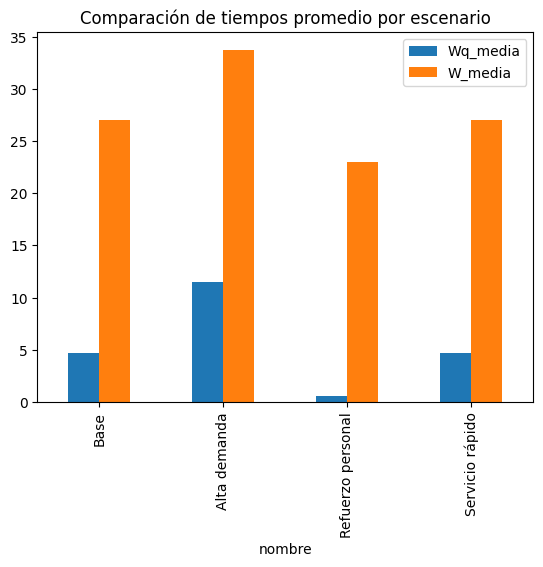

In [12]:
import matplotlib.pyplot as plt
df_result.plot(x="nombre", y=["Wq_media","W_media"], kind="bar")
plt.title("Comparación de tiempos promedio por escenario")
plt.show()